In [1]:
import pocketvna
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from stlab.devices.Vaunix_Phase import Vaunix_Phase
import pandas as pd
import time

Could not load "PocketVnaApi_x64" by systempath. Trying another one "C:\Users\Jacco\Documents\GitHub\bep-jacco-van-leenen\Code\PocketVnaApi_x64.dll"


In [2]:
# Basic variables and initializing the VNA and phase shifter
degrees = [0, 5, 10, 15, 20, 25]
labels = ["0 degrees", "5 degrees", "10 degrees", "15 degrees", "20 degrees", "25 degrees"]

ph1 = Vaunix_Phase(23869)
ph1.SetFrequency(4000000000)
print(ph1.GetFrequency())

plt.rcParams['figure.figsize'] = (10,6)
#plt.rcParams['figure.dpi'] = 300

driver = pocketvna.Driver()

print('Driver is created: {} devices connected..'.format(driver.count()))
for i in range(0, driver.count()):
    print('Device {}'.format(i))
    print('\t {}'.format(driver.info_at(i)))

if not driver.connect_to(0):
    print('Failed to connect')



status: 0
4000000000.0
Driver is created: 1 devices connected..
Device 0
	 {'index': 0, 'path:': b'\\\\?\\hid#vid_03eb&pid_2402#7&1fc8f206&0&0000#{4d1e55b2-f16f-11cf-88cb-001111000030}', 'version': 512, 'SN': '', 'product': 'PocketVNA', 'vendor': 'Martin', 'read': True, 'write': True}


In [3]:
# Setting the folder where the calibration is stored
folder_name = "Calibration"
dt = datetime.datetime.today()
date = "{}-{}-{}".format(dt.day, dt.month, dt.year)
if not os.path.exists(folder_name):
    os.mkdir(folder_name)
file_path = os.path.join(folder_name, date)

In [4]:
# Doing the calibration measurements
# Doing multiple measurements for different ranges

# Functions that will do the measurements for the calibration
def measure_open(START, END, AVERAGE, freq, name):
    s11, s21, s12, s22 = driver.scan(freq, AVERAGE, pocketvna.NetworkParams.S21)
    file_name = file_path + "_{}-{}MHz_".format(START, END) + name
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(file_name, data)

def measure_through(START, END, AVERAGE, freq, name):
    s11, s21, s12, s22 = driver.scan(freq, AVERAGE, pocketvna.NetworkParams.S21)
    file_name = file_path + "_{}-{}MHz_".format(START, END) + name
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(file_name, data)


ranges = [0, 1000, 2000, 3000, 4000, 5000]

# 2 for loops as I don't want to swith between open and through each loop
input("Press enter to to measure the open for both ports")
for START in ranges:
    END = START + 1000
    STEPS = 1000
    print("Measuring range: {}-{}MHz".format(START, END))
    AVERAGE = 10
    freq = np.linspace(START*1000000 + int((END - START)*1000000 / STEPS), END*1000000, STEPS, dtype=np.uint64)
    measure_open(START, END, AVERAGE, freq, "trans_open.dat")

input("Press enter to to measure the Through for both ports")
for START in ranges:
    END = START + 1000
    STEPS = 1000
    print("Measuring range: {}-{}MHz".format(START, END))
    AVERAGE = 10
    freq = np.linspace(START*1000000 + int((END - START) * 1000000 / STEPS), END*1000000, STEPS, dtype=np.uint64)
    measure_through(START, END, AVERAGE, freq, "trans_through.dat")
    



Press enter to to measure the open for both ports
Measuring range: 0-1000MHz
Measuring range: 1000-2000MHz
Measuring range: 2000-3000MHz
Measuring range: 3000-4000MHz
Measuring range: 4000-5000MHz
Measuring range: 5000-6000MHz
Press enter to to measure the Through for both ports
Measuring range: 0-1000MHz
Measuring range: 1000-2000MHz
Measuring range: 2000-3000MHz
Measuring range: 3000-4000MHz
Measuring range: 4000-5000MHz
Measuring range: 5000-6000MHz


In [19]:
# Measuring for the calibration
folder_name = "Calibration"
dt = datetime.datetime.today()
date = "{}-{}-{}".format(dt.day, dt.month, dt.year)
if not os.path.exists(folder_name):
    os.mkdir(folder_name)
calibration_path = os.path.join(folder_name, date)

START = 10000000
END = 1000000000
STEPS = 1000
freq = np.linspace(START, END, STEPS, dtype=np.uint64)
AVERAGE = 10


def measure_open(name):
    input("Press enter to to measure the open for both ports")
    s11, s21, s12, s22 = driver.scan(freq, AVERAGE, pocketvna.NetworkParams.S21)
    file_name = file_path + "_" + name
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(file_name, data)

def measure_through(name):
    input("Press enter to to measure the Through for both ports")
    s11, s21, s12, s22 = driver.scan(freq, AVERAGE, pocketvna.NetworkParams.S21)
    file_name = file_path + "_" + name
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(file_name, data)


def acquiring_data():
    s21 = np.zeros((STEPS, len(degrees)), dtype=np.complex128)
    for deg in degrees:
        ph1.SetPhase(deg)
        s11, s21[:, degrees.index(deg)], s12, s22 = driver.scan(freq, AVERAGE, pocketvna.NetworkParams.S21)
        print("Index: {}".format(degrees.index(deg)))
    return s21

def plot_amplitude(s21):
    f = np.zeros((STEPS, len(degrees)))
    f = f + freq[:, None]
    amp_s21 = np.sqrt(s21.real**2 + s21.imag**2)
    amp_s21 = 10*np.log10(amp_s21)
    plt.figure("amplitude")
    plt.plot(f, amp_s21, "-")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("amplitude (dB)")
    plt.legend(labels)
    plt.grid()
    plt.title("Amplitude with different phase shifts")
    
def plot_phase(s21):
    f = np.zeros((STEPS, len(degrees)))
    f = f + freq[:, None]
    phase = np.arctan2(s21.imag, s21.real)
    plt.figure("phase")
    plt.plot(freq, phase, "-")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("phase (degrees)")
    plt.legend(labels)
    plt.grid()
    plt.title("phase with different phase shifts")

def plot_relative_phase(s21):
    f = np.zeros((STEPS, len(degrees)))
    f = f + freq[:, None]
    phase = np.arctan2(s21.imag, s21.real)
    phase -= phase[:, 0, None]
    phase = phase * 180/np.pi
    phase[phase< -180] += 360
    phase[phase > 180] -= 360
    plt.figure("Relative Phase")
    plt.plot(freq, phase, ".")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("phase (degrees)")
    plt.legend(labels)
    plt.grid()
    plt.title("Relative Phase")

In [20]:
# Measuring
temp = acquiring_data()

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4


In [16]:
# Calibrating the Data
file_name = calibration_path + "_" + "trans_open.dat"
trans_open = np.loadtxt(file_name)
t_open = trans_open[:, 0] + trans_open[:, 1] * 1j

file_name = calibration_path + "_" + "trans_through.dat"
trans_through = np.loadtxt(file_name)
t_through = trans_through[:, 0] + trans_through[:, 1] * 1j

cal_s21 = np.zeros((STEPS, len(degrees)), dtype=np.complex128)
for i in range(len(degrees)):
    cal_s21[:, i] = (temp[:, i] - t_open) / (t_through - t_open)

In [15]:
# plotting
plot_amplitude(cal_s21)
plot_phase(cal_s21)
plot_relative_phase(cal_s21)

NameError: name 'plot_amplitude' is not defined

Measurement of 0-1000MHz
The shape of the frequency array: (1000,)
	Acquiring data for phase shift of 0 degrees
	Acquiring data for phase shift of 1 degrees
	Acquiring data for phase shift of 90 degrees
	Acquiring data for phase shift of 180 degrees
	Acquiring data for phase shift of 360 degrees
Data shape before appending: (5,)
Data shape after appending: (1000, 5)
The shape of the calibrated s21 array: (1000, 5)
Measurement of 1000-2000MHz
The shape of the frequency array: (2000,)
	Acquiring data for phase shift of 0 degrees
	Acquiring data for phase shift of 1 degrees
	Acquiring data for phase shift of 90 degrees
	Acquiring data for phase shift of 180 degrees
	Acquiring data for phase shift of 360 degrees
Data shape before appending: (1000, 5)
The shape of the calibrated s21 array: (2000, 5)
Measurement of 2000-3000MHz
The shape of the frequency array: (3000,)
	Acquiring data for phase shift of 0 degrees
	Acquiring data for phase shift of 1 degrees
	Acquiring data for phase shift of

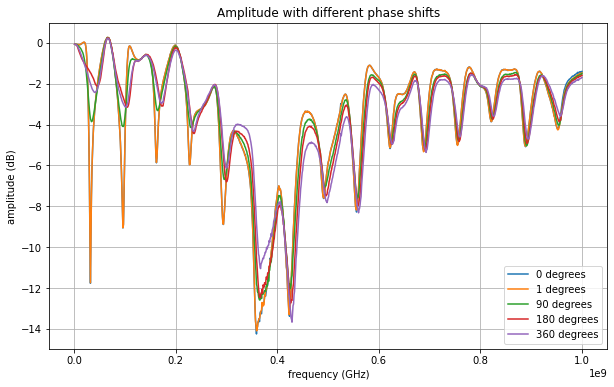

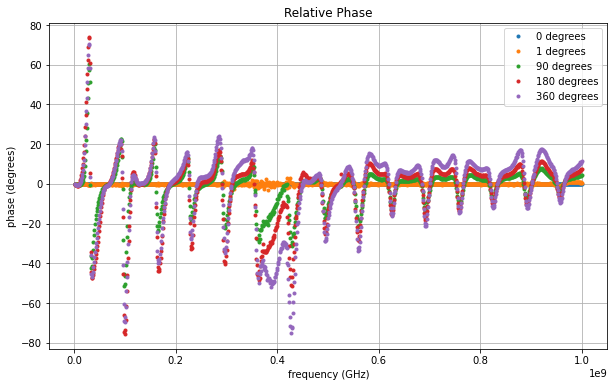

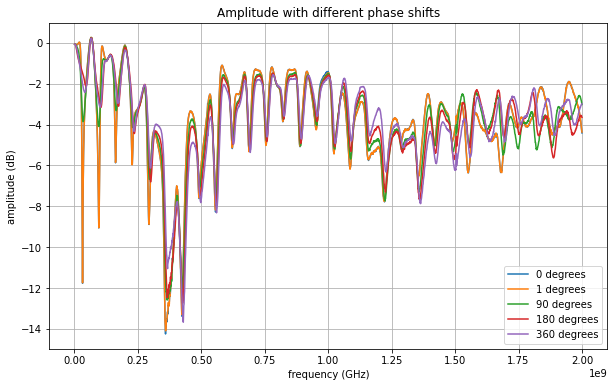

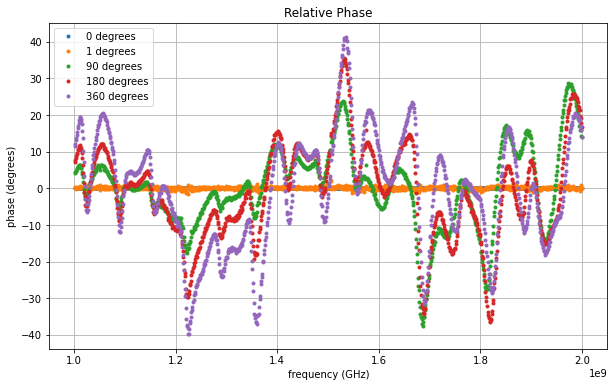

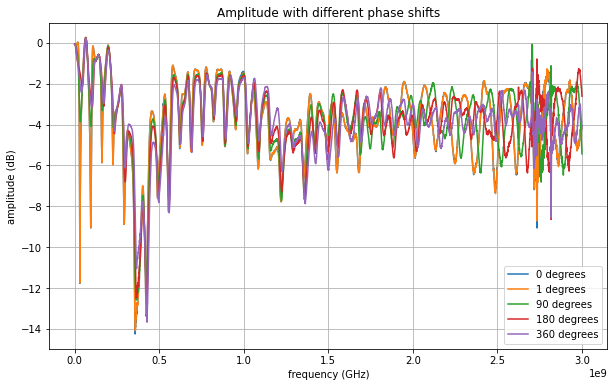

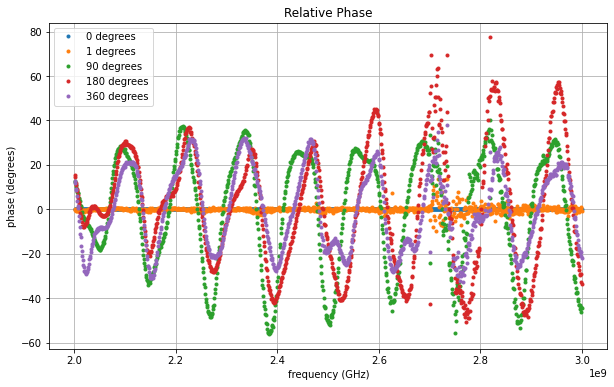

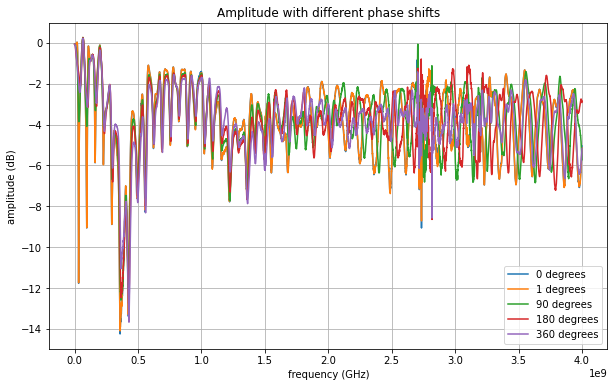

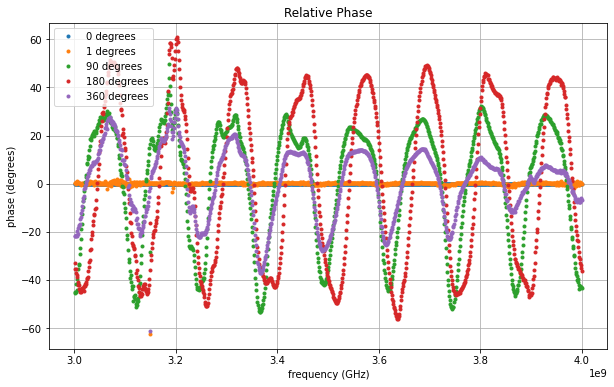

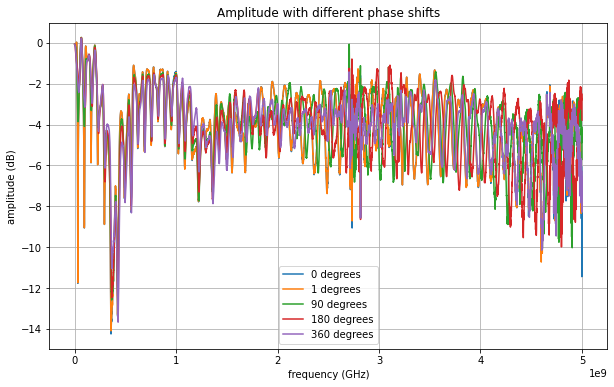

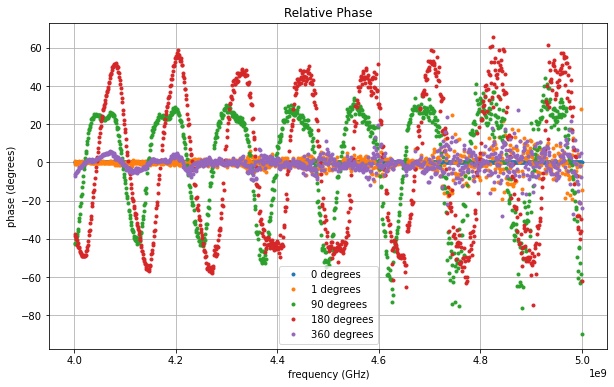

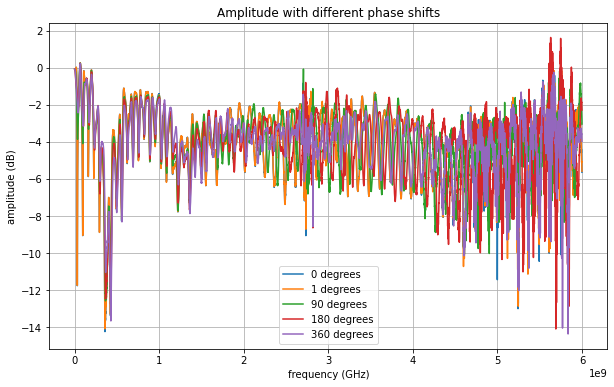

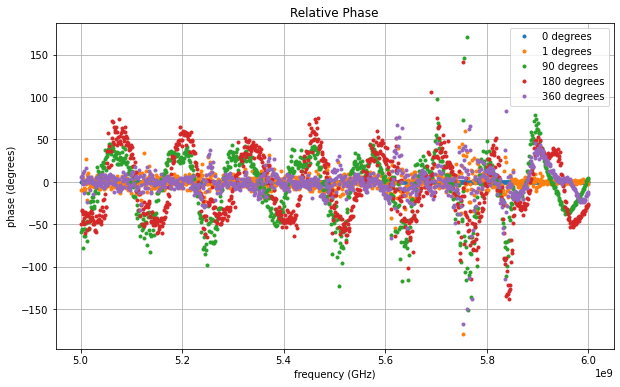

In [27]:
# Acquiring and plotting the data with multiple frequency sets

# Resetting the ranges and degrees variable, and adjusting the labels
ranges = [0, 1000, 2000, 3000, 4000, 5000]
degrees = [0, 1, 90, 180, 360]
labels = ["0 degrees", "1 degrees", "90 degrees", "180 degrees", "360 degrees"]

def acquiring_data(freq, AVERAGE, STEPS):
    s21 = np.zeros((STEPS, len(degrees)), dtype=np.complex128)
    for deg in degrees:
        ph1.SetPhase(deg)
        #ph1.SetFrequency(f)
        time.sleep(0.001)
        print("\tAcquiring data for phase shift of {} degrees".format(deg))
        s11, s21[:, degrees.index(deg)], s12, s22 = driver.scan(freq, AVERAGE, pocketvna.NetworkParams.S21)
    return s21

def calibrating_data(s21, START, END):
    file_name = file_path + "_{}-{}MHz_".format(START, END) + "trans_open.dat"
    trans_open = np.loadtxt(file_name)
    t_open = trans_open[:, 0] + trans_open[:, 1] * 1j

    file_name = file_path + "_{}-{}MHz_".format(START, END) + "trans_through.dat"
    trans_through = np.loadtxt(file_name)
    t_through = trans_through[:, 0] + trans_through[:, 1] * 1j

    cal_s21 = np.zeros((STEPS, len(degrees)), dtype=np.complex128)
    for i in range(len(degrees)):
        cal_s21[:, i] = (s21[:, i] - t_open) / (t_through - t_open)
    return cal_s21

def plot_amplitude(s21, STEPS, freq, START):
    f = np.zeros((len(freq), len(degrees)))
    f = f + freq[:, None]
    amp_s21 = np.sqrt(s21.real**2 + s21.imag**2)
    amp_s21 = 10*np.log10(amp_s21)
    plt.figure(ranges.index(START) + len(ranges))
    plt.plot(f, amp_s21, "-")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("amplitude (dB)")
    plt.legend(labels)
    plt.grid()
    plt.title("Amplitude with different phase shifts")
    
def plot_relative_phase(s21, STEPS, freq, START):
    f = np.zeros((len(freq), len(degrees)))
    f = f + freq[:, None]
    phase = np.arctan2(s21.imag, s21.real)
    phase -= phase[:, 0, None]
    phase = phase * 180/np.pi
    phase[phase< -180] += 360
    phase[phase > 180] -= 360
    plt.figure(ranges.index(START))
    plt.plot(freq, phase, ".")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("phase (degrees)")
    plt.legend(labels)
    plt.grid()
    plt.title("Relative Phase")

data_1 = np.array([0, 0, 0, 0, 0])
f_1 = np.array([])
for START in ranges:
    END = START + 1000
    print("Measurement of {}-{}MHz".format(START, END))
    STEPS = 1000
    AVERAGE = 10
    freq = np.linspace(START*1000000 + int((END - START) * 1000000 / STEPS), END*1000000, STEPS, dtype=np.uint64)
    f_1 = np.append(f_1, freq)
    print("The shape of the frequency array: {}".format(np.shape(f_1)))
    s21 = acquiring_data(freq, AVERAGE, STEPS)
    cal_s21 = calibrating_data(s21, START, END)
    print("Data shape before appending: {}".format(np.shape(data_1)))
    data_1= np.vstack((data_1, cal_s21))
    a, b = np.shape(data_1)
    if a % 1000 != 0:
        data_1 = np.delete(data_1, (0), axis=0)
        print("Data shape after appending: {}".format(np.shape(data_1)))
    print("The shape of the calibrated s21 array: {}".format(np.shape(data_1)))
    plot_amplitude(data_1, STEPS, f_1, START)
    plot_relative_phase(cal_s21, STEPS, freq, START)
    

